In [1]:
import time

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import IPython.display as ipd

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

import tensorflow.keras as keras
import tensorflow_docs as tfdocs
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint,LearningRateScheduler

2022-10-10 04:55:39.428382: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-10 04:55:39.428403: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
SEED = 42

import os
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import random 
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)

In [3]:
df = pd.read_csv('./data/full.csv')
pd.set_option('display.max_columns', None)
df.head()

,filename,tempo,total_beats,average_beats,chroma_stft_mean,chroma_stft_var,chroma_cq_mean,chroma_cq_var,chroma_cens_mean,chroma_cens_var,melspectrogram_mean,melspectrogram_var,mfcc_mean,mfcc_var,mfcc_delta_mean,mfcc_delta_var,rmse_mean,rmse_var,cent_mean,cent_var,spec_bw_mean,spec_bw_var,contrast_mean,contrast_var,rolloff_mean,rolloff_var,poly_mean,poly_var,tonnetz_mean,tonnetz_var,zcr_mean,zcr_var,harm_mean,harm_var,perc_mean,perc_var,frame_mean,frame_var,mfcc0_mean,mfcc0_var,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var
0,app_3001_4001_phnd_neg_0000.wav,184.570312,623,69.222222,0.515281,0.093347,0.443441,0.082742,0.249143,0.021261,0.038422,0.087981,-16.290880,8822.263672,0.014360,7.908705,0.043470,0.000818,1833.579533,511344.031721,1746.559035,144881.971359,19.095815,319.628529,3827.147750,3827.147750,0.294635,0.294635,0.015770,0.012313,0.114622,0.004777,2.852700e-06,0.001529,7.470300e-06,0.000618,1.729204,0.945134,-389.578400,1394.284424,134.581345,694.736450,-39.877445,331.621368,55.018433,417.293945,-36.944489,246.965225,18.573177,270.046539,-19.398455,136.647842,4.641793,166.485138,-5.455597,105.498589,-6.548687,143.077621,1.620288,80.328003,-14.974999,55.536694,1.443957,105.002190,-10.213489,52.869869,0.718760,75.744896,-10.669799,63.340282,1.811605,58.117188,-3.286546,54.268448,-2.719069,59.548176,-4.559987,70.774803
1,app_3001_4001_phnd_neg_0001.wav,151.999081,521,74.428571,0.487201,0.094461,0.542182,0.073359,0.274423,0.008025,0.204988,5.152482,-16.183870,7335.709961,-0.025494,18.772476,0.090213,0.008415,1927.253538,354369.575716,1627.620214,68783.641466,19.186873,305.084512,3762.586531,3762.586531,0.583882,0.583882,0.015399,0.006057,0.122172,0.003331,-1.651200e-06,0.002638,-2.788160e-05,0.009359,1.793741,0.910349,-350.381317,5990.534668,112.355591,596.321411,-50.575706,1418.432983,39.114021,507.006927,-33.239597,416.781708,3.573578,236.576492,-11.785189,178.042618,-1.014654,178.834152,4.223846,226.874054,-8.432135,133.631943,-0.922831,75.745110,-14.040901,129.677872,-1.542051,89.679306,-2.871657,86.871460,-2.855503,106.239403,-5.666375,90.256195,1.573594,105.070496,-0.742024,82.417496,-1.961745,119.312355,1.513660,101.014572
2,app_3001_4001_phnd_neg_0002.wav,112.347147,1614,146.727273,0.444244,0.099268,0.442014,0.083224,0.264430,0.013410,0.218063,3.372185,-15.555374,7140.790039,-0.001268,10.850190,0.099754,0.005438,1558.350787,286662.686733,1480.320551,108552.760715,19.694916,271.168203,3027.938960,3027.938960,0.626042,0.626042,0.000772,0.012586,0.094763,0.002338,-2.344000e-07,0.005676,1.925600e-06,0.005432,2.204735,1.657315,-340.841705,2853.958740,139.396652,639.750854,-44.360332,786.586487,34.030853,405.441681,-37.146648,447.909576,1.166850,360.854797,-11.257973,170.027328,-3.371944,226.699600,1.764457,140.997101,-9.144030,123.745407,0.545947,68.511703,-12.346964,91.306229,-3.448010,96.648567,-4.782896,96.846092,-3.135671,85.535561,-5.502390,73.079750,0.202623,72.040550,-4.021009,73.844353,-5.916223,103.834824,-2.939086,113.598824
3,app_3001_4001_phnd_neg_0003.wav,107.666016,2060,158.461538,0.454156,0.100834,0.424370,0.084435,0.257672,0.016938,0.214154,3.943239,-16.382410,7671.897461,-0.017487,10.714126,0.092214,0.006496,1501.958914,236170.752891,1468.111222,100434.245015,19.731574,280.614702,2981.342123,2981.342123,0.544611,0.544611,0.024137,0.015121,0.085925,0.001861,-4.205000e-07,0.006873,-2.248000e-07,0.004422,1.789098,1.241672,-359.523376,3351.339844,135.395157,589.953613,-40.197311,840.564270,32.704830,312.519379,-28.228338,411.952454,0.862422,276.248840,-9.016964,178.003738,-6.123117,168.513107,1.593995,121.375755,-7.000763,103.869049,-3.3311

## a) Plot the mean cross-validation accuracies on the final epoch for different numbers of hidden-layer neurons using a scatter plot. Limit the search space of the number of neurons to {64, 128, 256}.

In [4]:
df['label'] = df['filename'].str.split('_').str[-2]

In [5]:
df['label'].value_counts()

pos    92826
neg    89428
Name: label, dtype: int64

In [6]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout

In [7]:
def get_callbacks():
  return tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)

In [8]:
# callback to save the entire model
def saveModelsCallback(path,monitor,mode,save_freq):
    return tf.keras.callbacks.ModelCheckpoint(
        filepath=path,
        monitor = monitor,
        verbose = 0,
        save_best_only = True,
        save_weights_only = False,
        mode = mode,
        save_freq=save_freq,
)

In [9]:
class timecallback(tf.keras.callbacks.Callback):
    def __init__(self):
        self.last_time=0
        self.initial_time = time.time()
    def on_epoch_end(self,epoch,logs = {}):
        self.last_time = time.time() - self.initial_time

In [10]:
columns_to_drop = ['label','filename']

def split_dataset(df, columns_to_drop, test_size, random_state):
  label_encoder = preprocessing.LabelEncoder()

  df['label'] = label_encoder.fit_transform(df['label'])

  df_train, df_test = train_test_split(df, test_size=test_size, random_state=random_state)

  df_train2 = df_train.drop(columns_to_drop,axis=1)
  y_train2 = df_train['label'].to_numpy()

  df_test2 = df_test.drop(columns_to_drop,axis=1)
  y_test2 = df_test['label'].to_numpy() 

  return df_train2, y_train2, df_test2, y_test2

def preprocess_dataset(df_train, df_test):

  standard_scaler = preprocessing.StandardScaler()
  df_train_scaled = standard_scaler.fit_transform(df_train)

  df_test_scaled = standard_scaler.transform(df_test)

  return df_train_scaled, df_test_scaled

X_train, y_train, X_test, y_test = split_dataset(df, columns_to_drop, test_size=0.3, random_state=0) # positive labels being encoded as 1

X_train_scaled, X_test_scaled = preprocess_dataset(X_train, X_test)

### Functions to build and compile Model

In [11]:
# build the model
def build_model(input_shape, no_neurons_hidden,first_layer_units,dropout_prob):
    model = Sequential([
                InputLayer(input_shape),
                Dense(first_layer_units,activation='relu'),
                Dropout(dropout_prob),
                Dense(no_neurons_hidden,activation='relu'),
                Dropout(dropout_prob),
                Dense(no_neurons_hidden,activation='relu'),
                Dropout(dropout_prob),
                Dense(2,activation='softmax')
    ])
    return model

def compile_and_train(model,no_epochs,lr,batch_size,x_train,y_train,x_test,y_test,model_path):
    
    model.compile(optimizer = Adam(learning_rate = lr), 
                loss='sparse_categorical_crossentropy',
                metrics=[
                'accuracy',
                'mean_squared_error'
             ])
            
            # use an instance to persist the callback data
    timecallbackinstance = timecallback()

    history = model.fit(x_train, y_train,
                        epochs=no_epochs,
                        batch_size = batch_size,
                        verbose=0,
                        callbacks= [get_callbacks(),
                                    timecallbackinstance,
                                   saveModelsCallback(model_path,
                                                       'val_loss',
                                                       'min',
                                                       'epoch')
                                   ],
                        use_multiprocessing=True,
                        validation_data=(x_test, y_test))
    return history,timecallbackinstance

### function to train model

In [12]:
# function to train model
no_folds = 5
total_data = X_train_scaled.shape[0]
no_epochs = 100
lr = 0.001
dropout_prob = 0.2
no_neurons_hidden = 128
hidden_units = [64, 128, 256]
batch_size = 128


def train_exp(X, Y):
    
    err = []
    accuracy=[]
    last_epoch_times =[]
    histories = []
    
    
    for hidden_unit in hidden_units:
        histories_ =[]
        accuracy_ =[]
        err_ = []
        last_epoch_times_ = []
    
        for fold in range(no_folds):
            start, end = fold*(total_data//5), (fold+1)*(total_data//5)

            x_test, y_test = X[start:end], Y[start:end]
            x_train  = np.append(X[:start], X[end:], axis=0)
            y_train = np.append(Y[:start], Y[end:], axis=0)

            # specify dir to save weights of best epochs for each fold for each batch size
            model_path = './data/models/PartA_Q3a/{}_units_{}_fold_/best_epoch_weights'.format(hidden_unit,fold+1)
            
            model = build_model((x_train.shape[1],),
                                no_neurons_hidden,
                                hidden_unit,
                               dropout_prob)
            history,timecallbackinstance = compile_and_train(model,
                                        no_epochs,
                                        lr,
                                        batch_size,
                                        x_train,
                                        y_train,
                                        x_test,
                                        y_test,
                                        model_path)
            
            err_.append(min(history.history['val_loss']))
            accuracy_.append(history.history['val_accuracy'][-1])
            last_epoch_times_.append(timecallbackinstance.last_time)
            histories_.append(history)
    
        err.append(np.mean(err_))
        accuracy.append(np.mean(accuracy_))
        last_epoch_times.append(np.mean(last_epoch_times_))
        histories.append(histories_)

    return err,accuracy,last_epoch_times,histories

In [13]:
# perform experiments
err,accuracy,last_epoch_times,histories = train_exp(X_train_scaled,y_train)

2022-10-10 04:55:43.461587: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-10 04:55:43.462081: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-10 04:55:43.462191: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-10-10 04:55:43.462292: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-10-10 04:55:43.464911: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co


Epoch 1: val_loss improved from inf to 0.68635, saving model to ./data/models/PartA_Q3a/64_units_1_fold_/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/64_units_1_fold_/best_epoch_weights/assets

Epoch 2: val_loss improved from 0.68635 to 0.68353, saving model to ./data/models/PartA_Q3a/64_units_1_fold_/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/64_units_1_fold_/best_epoch_weights/assets

Epoch 3: val_loss improved from 0.68353 to 0.68191, saving model to ./data/models/PartA_Q3a/64_units_1_fold_/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/64_units_1_fold_/best_epoch_weights/assets

Epoch 4: val_loss improved from 0.68191 to 0.68107, saving model to ./data/models/PartA_Q3a/64_units_1_fold_/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/64_units_1_fold_/best_epoch_weights/assets

Epoch 5: val_loss improved from 0.68107 to 0.67894, saving model to ./data/mode


Epoch 49: val_loss improved from 0.64079 to 0.64041, saving model to ./data/models/PartA_Q3a/64_units_1_fold_/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/64_units_1_fold_/best_epoch_weights/assets

Epoch 50: val_loss improved from 0.64041 to 0.63877, saving model to ./data/models/PartA_Q3a/64_units_1_fold_/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/64_units_1_fold_/best_epoch_weights/assets

Epoch 51: val_loss improved from 0.63877 to 0.63848, saving model to ./data/models/PartA_Q3a/64_units_1_fold_/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/64_units_1_fold_/best_epoch_weights/assets

Epoch 52: val_loss did not improve from 0.63848

Epoch 53: val_loss improved from 0.63848 to 0.63784, saving model to ./data/models/PartA_Q3a/64_units_1_fold_/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/64_units_1_fold_/best_epoch_weights/assets

Epoch 54: val_loss did


Epoch 13: val_loss improved from 0.66647 to 0.66641, saving model to ./data/models/PartA_Q3a/64_units_2_fold_/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/64_units_2_fold_/best_epoch_weights/assets

Epoch 14: val_loss improved from 0.66641 to 0.66439, saving model to ./data/models/PartA_Q3a/64_units_2_fold_/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/64_units_2_fold_/best_epoch_weights/assets

Epoch 15: val_loss improved from 0.66439 to 0.66114, saving model to ./data/models/PartA_Q3a/64_units_2_fold_/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/64_units_2_fold_/best_epoch_weights/assets

Epoch 16: val_loss did not improve from 0.66114

Epoch 17: val_loss improved from 0.66114 to 0.65963, saving model to ./data/models/PartA_Q3a/64_units_2_fold_/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/64_units_2_fold_/best_epoch_weights/assets

Epoch 18: val_loss imp


Epoch 76: val_loss improved from 0.63159 to 0.63041, saving model to ./data/models/PartA_Q3a/64_units_2_fold_/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/64_units_2_fold_/best_epoch_weights/assets

Epoch 77: val_loss improved from 0.63041 to 0.63007, saving model to ./data/models/PartA_Q3a/64_units_2_fold_/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/64_units_2_fold_/best_epoch_weights/assets

Epoch 78: val_loss improved from 0.63007 to 0.62953, saving model to ./data/models/PartA_Q3a/64_units_2_fold_/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/64_units_2_fold_/best_epoch_weights/assets

Epoch 79: val_loss did not improve from 0.62953

Epoch 80: val_loss did not improve from 0.62953

Epoch 81: val_loss improved from 0.62953 to 0.62938, saving model to ./data/models/PartA_Q3a/64_units_2_fold_/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/64_units_2_fold_/


Epoch 25: val_loss improved from 0.65325 to 0.65293, saving model to ./data/models/PartA_Q3a/64_units_3_fold_/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/64_units_3_fold_/best_epoch_weights/assets

Epoch 26: val_loss did not improve from 0.65293

Epoch 27: val_loss improved from 0.65293 to 0.65232, saving model to ./data/models/PartA_Q3a/64_units_3_fold_/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/64_units_3_fold_/best_epoch_weights/assets

Epoch 28: val_loss improved from 0.65232 to 0.65108, saving model to ./data/models/PartA_Q3a/64_units_3_fold_/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/64_units_3_fold_/best_epoch_weights/assets

Epoch 29: val_loss did not improve from 0.65108

Epoch 30: val_loss improved from 0.65108 to 0.64994, saving model to ./data/models/PartA_Q3a/64_units_3_fold_/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/64_units_3_fold_/

INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/64_units_3_fold_/best_epoch_weights/assets

Epoch 92: val_loss improved from 0.62870 to 0.62852, saving model to ./data/models/PartA_Q3a/64_units_3_fold_/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/64_units_3_fold_/best_epoch_weights/assets

Epoch 93: val_loss did not improve from 0.62852

Epoch 94: val_loss did not improve from 0.62852

Epoch 95: val_loss improved from 0.62852 to 0.62792, saving model to ./data/models/PartA_Q3a/64_units_3_fold_/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/64_units_3_fold_/best_epoch_weights/assets

Epoch 96: val_loss did not improve from 0.62792

Epoch 97: val_loss did not improve from 0.62792

Epoch 98: val_loss did not improve from 0.62792

Epoch 99: val_loss did not improve from 0.62792

Epoch 100: val_loss did not improve from 0.62792

Epoch 1: val_loss improved from inf to 0.68626, saving model to ./data/models/PartA_Q3a/6

INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/64_units_4_fold_/best_epoch_weights/assets

Epoch 37: val_loss improved from 0.64703 to 0.64690, saving model to ./data/models/PartA_Q3a/64_units_4_fold_/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/64_units_4_fold_/best_epoch_weights/assets

Epoch 38: val_loss improved from 0.64690 to 0.64651, saving model to ./data/models/PartA_Q3a/64_units_4_fold_/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/64_units_4_fold_/best_epoch_weights/assets

Epoch 39: val_loss improved from 0.64651 to 0.64622, saving model to ./data/models/PartA_Q3a/64_units_4_fold_/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/64_units_4_fold_/best_epoch_weights/assets

Epoch 40: val_loss improved from 0.64622 to 0.64519, saving model to ./data/models/PartA_Q3a/64_units_4_fold_/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/64_units_4_fo


Epoch 2: val_loss improved from 0.68575 to 0.68429, saving model to ./data/models/PartA_Q3a/64_units_5_fold_/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/64_units_5_fold_/best_epoch_weights/assets

Epoch 3: val_loss improved from 0.68429 to 0.68094, saving model to ./data/models/PartA_Q3a/64_units_5_fold_/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/64_units_5_fold_/best_epoch_weights/assets

Epoch 4: val_loss improved from 0.68094 to 0.67892, saving model to ./data/models/PartA_Q3a/64_units_5_fold_/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/64_units_5_fold_/best_epoch_weights/assets

Epoch 5: val_loss improved from 0.67892 to 0.67806, saving model to ./data/models/PartA_Q3a/64_units_5_fold_/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/64_units_5_fold_/best_epoch_weights/assets

Epoch 6: val_loss improved from 0.67806 to 0.67677, saving model to ./data/

INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/64_units_5_fold_/best_epoch_weights/assets

Epoch 41: val_loss did not improve from 0.64133

Epoch 42: val_loss did not improve from 0.64133

Epoch 43: val_loss improved from 0.64133 to 0.64079, saving model to ./data/models/PartA_Q3a/64_units_5_fold_/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/64_units_5_fold_/best_epoch_weights/assets

Epoch 44: val_loss improved from 0.64079 to 0.64007, saving model to ./data/models/PartA_Q3a/64_units_5_fold_/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/64_units_5_fold_/best_epoch_weights/assets

Epoch 45: val_loss did not improve from 0.64007

Epoch 46: val_loss improved from 0.64007 to 0.63811, saving model to ./data/models/PartA_Q3a/64_units_5_fold_/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/64_units_5_fold_/best_epoch_weights/assets

Epoch 47: val_loss did not improve from 0.63811

Epoch

INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/128_units_1_fold_/best_epoch_weights/assets

Epoch 13: val_loss improved from 0.65592 to 0.65509, saving model to ./data/models/PartA_Q3a/128_units_1_fold_/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/128_units_1_fold_/best_epoch_weights/assets

Epoch 14: val_loss improved from 0.65509 to 0.65431, saving model to ./data/models/PartA_Q3a/128_units_1_fold_/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/128_units_1_fold_/best_epoch_weights/assets

Epoch 15: val_loss improved from 0.65431 to 0.64820, saving model to ./data/models/PartA_Q3a/128_units_1_fold_/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/128_units_1_fold_/best_epoch_weights/assets

Epoch 16: val_loss did not improve from 0.64820

Epoch 17: val_loss improved from 0.64820 to 0.64552, saving model to ./data/models/PartA_Q3a/128_units_1_fold_/best_epoch_weights
INFO:tensorflow


Epoch 58: val_loss did not improve from 0.60482

Epoch 59: val_loss did not improve from 0.60482

Epoch 60: val_loss improved from 0.60482 to 0.60441, saving model to ./data/models/PartA_Q3a/128_units_1_fold_/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/128_units_1_fold_/best_epoch_weights/assets

Epoch 61: val_loss improved from 0.60441 to 0.60354, saving model to ./data/models/PartA_Q3a/128_units_1_fold_/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/128_units_1_fold_/best_epoch_weights/assets

Epoch 62: val_loss improved from 0.60354 to 0.60282, saving model to ./data/models/PartA_Q3a/128_units_1_fold_/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/128_units_1_fold_/best_epoch_weights/assets

Epoch 63: val_loss improved from 0.60282 to 0.60282, saving model to ./data/models/PartA_Q3a/128_units_1_fold_/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/128_units_

INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/128_units_2_fold_/best_epoch_weights/assets

Epoch 22: val_loss improved from 0.63941 to 0.63756, saving model to ./data/models/PartA_Q3a/128_units_2_fold_/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/128_units_2_fold_/best_epoch_weights/assets

Epoch 23: val_loss improved from 0.63756 to 0.63661, saving model to ./data/models/PartA_Q3a/128_units_2_fold_/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/128_units_2_fold_/best_epoch_weights/assets

Epoch 24: val_loss improved from 0.63661 to 0.63473, saving model to ./data/models/PartA_Q3a/128_units_2_fold_/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/128_units_2_fold_/best_epoch_weights/assets

Epoch 25: val_loss improved from 0.63473 to 0.63248, saving model to ./data/models/PartA_Q3a/128_units_2_fold_/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/128_u


Epoch 74: val_loss improved from 0.60660 to 0.60450, saving model to ./data/models/PartA_Q3a/128_units_2_fold_/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/128_units_2_fold_/best_epoch_weights/assets

Epoch 75: val_loss did not improve from 0.60450

Epoch 76: val_loss did not improve from 0.60450

Epoch 77: val_loss did not improve from 0.60450

Epoch 78: val_loss did not improve from 0.60450

Epoch 79: val_loss did not improve from 0.60450

Epoch 80: val_loss did not improve from 0.60450

Epoch 81: val_loss did not improve from 0.60450

Epoch 82: val_loss improved from 0.60450 to 0.60277, saving model to ./data/models/PartA_Q3a/128_units_2_fold_/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/128_units_2_fold_/best_epoch_weights/assets

Epoch 83: val_loss did not improve from 0.60277

Epoch 84: val_loss did not improve from 0.60277

Epoch 85: val_loss did not improve from 0.60277

Epoch 86: val_loss did not improve from 0


Epoch 29: val_loss did not improve from 0.62971

Epoch 30: val_loss improved from 0.62971 to 0.62644, saving model to ./data/models/PartA_Q3a/128_units_3_fold_/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/128_units_3_fold_/best_epoch_weights/assets

Epoch 31: val_loss improved from 0.62644 to 0.62618, saving model to ./data/models/PartA_Q3a/128_units_3_fold_/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/128_units_3_fold_/best_epoch_weights/assets

Epoch 32: val_loss improved from 0.62618 to 0.62397, saving model to ./data/models/PartA_Q3a/128_units_3_fold_/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/128_units_3_fold_/best_epoch_weights/assets

Epoch 33: val_loss did not improve from 0.62397

Epoch 34: val_loss improved from 0.62397 to 0.62334, saving model to ./data/models/PartA_Q3a/128_units_3_fold_/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/128_units_


Epoch 100: val_loss did not improve from 0.59866

Epoch 1: val_loss improved from inf to 0.68450, saving model to ./data/models/PartA_Q3a/128_units_4_fold_/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/128_units_4_fold_/best_epoch_weights/assets

Epoch 2: val_loss improved from 0.68450 to 0.68265, saving model to ./data/models/PartA_Q3a/128_units_4_fold_/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/128_units_4_fold_/best_epoch_weights/assets

Epoch 3: val_loss improved from 0.68265 to 0.68016, saving model to ./data/models/PartA_Q3a/128_units_4_fold_/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/128_units_4_fold_/best_epoch_weights/assets

Epoch 4: val_loss improved from 0.68016 to 0.67718, saving model to ./data/models/PartA_Q3a/128_units_4_fold_/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/128_units_4_fold_/best_epoch_weights/assets

Epoch 5: val_loss imp

INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/128_units_4_fold_/best_epoch_weights/assets

Epoch 38: val_loss did not improve from 0.62278

Epoch 39: val_loss improved from 0.62278 to 0.62169, saving model to ./data/models/PartA_Q3a/128_units_4_fold_/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/128_units_4_fold_/best_epoch_weights/assets

Epoch 40: val_loss did not improve from 0.62169

Epoch 41: val_loss improved from 0.62169 to 0.62140, saving model to ./data/models/PartA_Q3a/128_units_4_fold_/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/128_units_4_fold_/best_epoch_weights/assets

Epoch 42: val_loss improved from 0.62140 to 0.61803, saving model to ./data/models/PartA_Q3a/128_units_4_fold_/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/128_units_4_fold_/best_epoch_weights/assets

Epoch 43: val_loss did not improve from 0.61803

Epoch 44: val_loss improved from 0.61803 to 0.6


Epoch 6: val_loss improved from 0.67625 to 0.67348, saving model to ./data/models/PartA_Q3a/128_units_5_fold_/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/128_units_5_fold_/best_epoch_weights/assets

Epoch 7: val_loss improved from 0.67348 to 0.66984, saving model to ./data/models/PartA_Q3a/128_units_5_fold_/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/128_units_5_fold_/best_epoch_weights/assets

Epoch 8: val_loss improved from 0.66984 to 0.66648, saving model to ./data/models/PartA_Q3a/128_units_5_fold_/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/128_units_5_fold_/best_epoch_weights/assets

Epoch 9: val_loss improved from 0.66648 to 0.66501, saving model to ./data/models/PartA_Q3a/128_units_5_fold_/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/128_units_5_fold_/best_epoch_weights/assets

Epoch 10: val_loss improved from 0.66501 to 0.66171, saving model t


Epoch 46: val_loss improved from 0.61738 to 0.61657, saving model to ./data/models/PartA_Q3a/128_units_5_fold_/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/128_units_5_fold_/best_epoch_weights/assets

Epoch 47: val_loss did not improve from 0.61657

Epoch 48: val_loss improved from 0.61657 to 0.61486, saving model to ./data/models/PartA_Q3a/128_units_5_fold_/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/128_units_5_fold_/best_epoch_weights/assets

Epoch 49: val_loss improved from 0.61486 to 0.61460, saving model to ./data/models/PartA_Q3a/128_units_5_fold_/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/128_units_5_fold_/best_epoch_weights/assets

Epoch 50: val_loss did not improve from 0.61460

Epoch 51: val_loss did not improve from 0.61460

Epoch 52: val_loss did not improve from 0.61460

Epoch 53: val_loss improved from 0.61460 to 0.61156, saving model to ./data/models/PartA_Q3a/128_unit

INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/256_units_1_fold_/best_epoch_weights/assets

Epoch 8: val_loss improved from 0.66462 to 0.65985, saving model to ./data/models/PartA_Q3a/256_units_1_fold_/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/256_units_1_fold_/best_epoch_weights/assets

Epoch 9: val_loss improved from 0.65985 to 0.65489, saving model to ./data/models/PartA_Q3a/256_units_1_fold_/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/256_units_1_fold_/best_epoch_weights/assets

Epoch 10: val_loss improved from 0.65489 to 0.64996, saving model to ./data/models/PartA_Q3a/256_units_1_fold_/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/256_units_1_fold_/best_epoch_weights/assets

Epoch 11: val_loss improved from 0.64996 to 0.64730, saving model to ./data/models/PartA_Q3a/256_units_1_fold_/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/256_uni


Epoch 54: val_loss did not improve from 0.58524

Epoch 55: val_loss did not improve from 0.58524

Epoch 56: val_loss improved from 0.58524 to 0.58292, saving model to ./data/models/PartA_Q3a/256_units_1_fold_/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/256_units_1_fold_/best_epoch_weights/assets

Epoch 57: val_loss did not improve from 0.58292

Epoch 58: val_loss improved from 0.58292 to 0.58245, saving model to ./data/models/PartA_Q3a/256_units_1_fold_/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/256_units_1_fold_/best_epoch_weights/assets

Epoch 59: val_loss improved from 0.58245 to 0.58155, saving model to ./data/models/PartA_Q3a/256_units_1_fold_/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/256_units_1_fold_/best_epoch_weights/assets

Epoch 60: val_loss did not improve from 0.58155

Epoch 61: val_loss did not improve from 0.58155

Epoch 62: val_loss did not improve from 0.58155

Epo

INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/256_units_2_fold_/best_epoch_weights/assets

Epoch 15: val_loss improved from 0.63785 to 0.63555, saving model to ./data/models/PartA_Q3a/256_units_2_fold_/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/256_units_2_fold_/best_epoch_weights/assets

Epoch 16: val_loss improved from 0.63555 to 0.63432, saving model to ./data/models/PartA_Q3a/256_units_2_fold_/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/256_units_2_fold_/best_epoch_weights/assets

Epoch 17: val_loss improved from 0.63432 to 0.63017, saving model to ./data/models/PartA_Q3a/256_units_2_fold_/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/256_units_2_fold_/best_epoch_weights/assets

Epoch 18: val_loss improved from 0.63017 to 0.62701, saving model to ./data/models/PartA_Q3a/256_units_2_fold_/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/256_u

INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/256_units_2_fold_/best_epoch_weights/assets

Epoch 63: val_loss improved from 0.58151 to 0.58139, saving model to ./data/models/PartA_Q3a/256_units_2_fold_/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/256_units_2_fold_/best_epoch_weights/assets

Epoch 64: val_loss did not improve from 0.58139

Epoch 65: val_loss improved from 0.58139 to 0.58075, saving model to ./data/models/PartA_Q3a/256_units_2_fold_/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/256_units_2_fold_/best_epoch_weights/assets

Epoch 66: val_loss did not improve from 0.58075

Epoch 67: val_loss did not improve from 0.58075

Epoch 68: val_loss did not improve from 0.58075

Epoch 69: val_loss improved from 0.58075 to 0.57929, saving model to ./data/models/PartA_Q3a/256_units_2_fold_/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/256_units_2_fold_/best_epoch_weights/assets

INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/256_units_3_fold_/best_epoch_weights/assets

Epoch 21: val_loss improved from 0.62156 to 0.62143, saving model to ./data/models/PartA_Q3a/256_units_3_fold_/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/256_units_3_fold_/best_epoch_weights/assets

Epoch 22: val_loss improved from 0.62143 to 0.61780, saving model to ./data/models/PartA_Q3a/256_units_3_fold_/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/256_units_3_fold_/best_epoch_weights/assets

Epoch 23: val_loss did not improve from 0.61780

Epoch 24: val_loss improved from 0.61780 to 0.61501, saving model to ./data/models/PartA_Q3a/256_units_3_fold_/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/256_units_3_fold_/best_epoch_weights/assets

Epoch 25: val_loss improved from 0.61501 to 0.61299, saving model to ./data/models/PartA_Q3a/256_units_3_fold_/best_epoch_weights
INFO:tensorflow


Epoch 81: val_loss improved from 0.58052 to 0.58049, saving model to ./data/models/PartA_Q3a/256_units_3_fold_/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/256_units_3_fold_/best_epoch_weights/assets

Epoch 82: val_loss did not improve from 0.58049

Epoch 83: val_loss improved from 0.58049 to 0.57947, saving model to ./data/models/PartA_Q3a/256_units_3_fold_/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/256_units_3_fold_/best_epoch_weights/assets

Epoch 84: val_loss did not improve from 0.57947

Epoch 85: val_loss did not improve from 0.57947

Epoch 86: val_loss improved from 0.57947 to 0.57910, saving model to ./data/models/PartA_Q3a/256_units_3_fold_/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/256_units_3_fold_/best_epoch_weights/assets

Epoch 87: val_loss improved from 0.57910 to 0.57794, saving model to ./data/models/PartA_Q3a/256_units_3_fold_/best_epoch_weights
INFO:tensorflow:Asse


Epoch 29: val_loss improved from 0.61556 to 0.61356, saving model to ./data/models/PartA_Q3a/256_units_4_fold_/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/256_units_4_fold_/best_epoch_weights/assets

Epoch 30: val_loss improved from 0.61356 to 0.61294, saving model to ./data/models/PartA_Q3a/256_units_4_fold_/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/256_units_4_fold_/best_epoch_weights/assets

Epoch 31: val_loss did not improve from 0.61294

Epoch 32: val_loss improved from 0.61294 to 0.60915, saving model to ./data/models/PartA_Q3a/256_units_4_fold_/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/256_units_4_fold_/best_epoch_weights/assets

Epoch 33: val_loss did not improve from 0.60915

Epoch 34: val_loss did not improve from 0.60915

Epoch 35: val_loss improved from 0.60915 to 0.60819, saving model to ./data/models/PartA_Q3a/256_units_4_fold_/best_epoch_weights
INFO:tensorflow:Asse

INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/256_units_4_fold_/best_epoch_weights/assets

Epoch 93: val_loss did not improve from 0.58388

Epoch 94: val_loss improved from 0.58388 to 0.58229, saving model to ./data/models/PartA_Q3a/256_units_4_fold_/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/256_units_4_fold_/best_epoch_weights/assets

Epoch 95: val_loss did not improve from 0.58229

Epoch 96: val_loss did not improve from 0.58229

Epoch 97: val_loss did not improve from 0.58229

Epoch 98: val_loss did not improve from 0.58229

Epoch 99: val_loss did not improve from 0.58229

Epoch 100: val_loss did not improve from 0.58229

Epoch 1: val_loss improved from inf to 0.68364, saving model to ./data/models/PartA_Q3a/256_units_5_fold_/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/256_units_5_fold_/best_epoch_weights/assets

Epoch 2: val_loss improved from 0.68364 to 0.68204, saving model to ./data/models/PartA_Q

INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/256_units_5_fold_/best_epoch_weights/assets

Epoch 40: val_loss improved from 0.59229 to 0.59129, saving model to ./data/models/PartA_Q3a/256_units_5_fold_/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/256_units_5_fold_/best_epoch_weights/assets

Epoch 41: val_loss did not improve from 0.59129

Epoch 42: val_loss did not improve from 0.59129

Epoch 43: val_loss improved from 0.59129 to 0.59121, saving model to ./data/models/PartA_Q3a/256_units_5_fold_/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/256_units_5_fold_/best_epoch_weights/assets

Epoch 44: val_loss improved from 0.59121 to 0.58991, saving model to ./data/models/PartA_Q3a/256_units_5_fold_/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3a/256_units_5_fold_/best_epoch_weights/assets

Epoch 45: val_loss improved from 0.58991 to 0.58742, saving model to ./data/models/PartA_Q3a/256

## a) Plot the mean cross-validation accuracies on the final epoch for different
numbers of hidden-layer neurons using a scatter plot. Limit the search space of the
number of neurons to {64, 128, 256}.
3
Continue using 5-fold cross validation on training dataset.

Text(0, 0.5, 'mean cross validation accuracy')

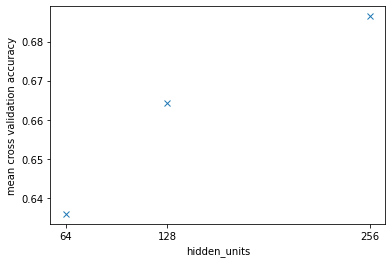

In [14]:
plt.figure(1)
plt.plot(hidden_units, accuracy, marker = 'x', linestyle = 'None')
plt.xticks(hidden_units)
plt.xlabel('hidden_units')
plt.ylabel('mean cross validation accuracy')

## b) Select the optimal number of neurons for the hidden layer. State the rationale for your selection.

256 is the best number of neurons to use for the first hidden layer as it has the highest cross validation accuracy among all the batch sizes tried

## c) Plot the train and test accuracies against training epochs with the optimal number of neurons using a line plot.

In [15]:
model_path = './data/models/PartA_Q3c/best_epoch_weights'

optimum_model = build_model((X_train_scaled.shape[1],),
                            128,
                            256,
                            0.2)
history,timecallbackinstance = compile_and_train(optimum_model,
                            no_epochs= 100,
                            lr= 0.001,
                            batch_size=128,
                            x_train= X_train_scaled,
                            y_train = y_train,
                            x_test = X_test_scaled,
                            y_test = y_test,
                            model_path=model_path)




Epoch 1: val_loss improved from inf to 0.68352, saving model to ./data/models/PartA_Q3c/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3c/best_epoch_weights/assets

Epoch 2: val_loss improved from 0.68352 to 0.68139, saving model to ./data/models/PartA_Q3c/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3c/best_epoch_weights/assets

Epoch 3: val_loss improved from 0.68139 to 0.67975, saving model to ./data/models/PartA_Q3c/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3c/best_epoch_weights/assets

Epoch 4: val_loss improved from 0.67975 to 0.67208, saving model to ./data/models/PartA_Q3c/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3c/best_epoch_weights/assets

Epoch 5: val_loss improved from 0.67208 to 0.67002, saving model to ./data/models/PartA_Q3c/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3c/best_epoch_weights/assets

Epoch 6: val_loss 


Epoch 50: val_loss improved from 0.57192 to 0.57175, saving model to ./data/models/PartA_Q3c/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3c/best_epoch_weights/assets

Epoch 51: val_loss improved from 0.57175 to 0.57058, saving model to ./data/models/PartA_Q3c/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3c/best_epoch_weights/assets

Epoch 52: val_loss improved from 0.57058 to 0.56955, saving model to ./data/models/PartA_Q3c/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3c/best_epoch_weights/assets

Epoch 53: val_loss did not improve from 0.56955

Epoch 54: val_loss did not improve from 0.56955

Epoch 55: val_loss improved from 0.56955 to 0.56811, saving model to ./data/models/PartA_Q3c/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3c/best_epoch_weights/assets

Epoch 56: val_loss improved from 0.56811 to 0.56703, saving model to ./data/models/PartA_Q3c/best_epoch_weigh

In [16]:
# hidden units 256
doc_histories={}
doc_histories["optimum_model"] = history

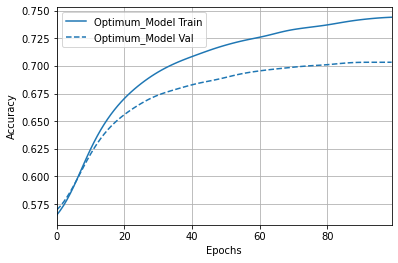

In [17]:
import tensorflow_docs.plots
plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy', smoothing_std=10)
plotter.plot(doc_histories)

## d) How does dropouts work, and what is the purpose of dropouts?

dropouts work by dropping a certain percentage of neurons in a layer in every pass. This allows us to create different networks on each pass. essentially we are training different neural networks at each propagation.
Since the different networks will overfit in different ways, the net effect of the overfitting is decreased while using dropouts

## e) Besides early stopping and dropout, what is another approach that you could take to address overfitting in the model, and how does it work? Implement the approach.

We can introduce a penalty to prevent the weights from getting too big and overfitting

In [18]:
# build the regularised model
def build_regularised_model(input_shape, no_neurons_hidden,first_layer_units,dropout_prob):
    model = Sequential([
                InputLayer(input_shape),
                Dense(first_layer_units,activation='relu',kernel_regularizer=l2(0.001)),
                Dropout(dropout_prob),
                Dense(no_neurons_hidden,activation='relu', kernel_regularizer=l2(0.001)),
                Dropout(dropout_prob),
                Dense(no_neurons_hidden,activation='relu', kernel_regularizer=l2(0.001)),
                Dropout(dropout_prob),
                Dense(2,activation='softmax')
    ])
    return model

In [19]:
model_path = './data/models/PartA_Q3e/best_epoch_weights'

regularised_model = build_regularised_model((X_train_scaled.shape[1],),
                            128,
                            256,
                            0.2)
history,timecallbackinstance = compile_and_train(regularised_model,
                            no_epochs= 100,
                            lr= 0.001,
                            batch_size=128,
                            x_train= X_train_scaled,
                            y_train = y_train,
                            x_test = X_test_scaled,
                            y_test = y_test,
                            model_path=model_path)


Epoch 1: val_loss improved from inf to 0.69954, saving model to ./data/models/PartA_Q3e/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3e/best_epoch_weights/assets

Epoch 2: val_loss improved from 0.69954 to 0.68923, saving model to ./data/models/PartA_Q3e/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3e/best_epoch_weights/assets

Epoch 3: val_loss did not improve from 0.68923

Epoch 4: val_loss improved from 0.68923 to 0.68795, saving model to ./data/models/PartA_Q3e/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3e/best_epoch_weights/assets

Epoch 5: val_loss improved from 0.68795 to 0.68761, saving model to ./data/models/PartA_Q3e/best_epoch_weights
INFO:tensorflow:Assets written to: ./data/models/PartA_Q3e/best_epoch_weights/assets

Epoch 6: val_loss did not improve from 0.68761

Epoch 7: val_loss did not improve from 0.68761

Epoch 8: val_loss improved from 0.68761 to 0.68758, saving model to ./d

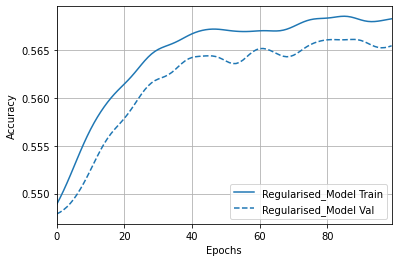

In [20]:
regularised_histories = {}
regularised_histories["regularised_model"] = history
plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy', smoothing_std=10)
plotter.plot(regularised_histories)

### How does this work:

L2 regularisation introduces a weight penalty to ensure that weights do not get overly large during training, thus preventing overfitting